# Analytics dos dados na camada bronze - Olist Dataset

## 1. Objetivo e Contexto

Este notebook realiza a análise exploratória dos dados brutos (Camada Bronze) do dataset público de E-commerce da Olist. O objetivo é entender profundamente a estrutura, qualidade, distribuição e relações nos dados, com foco especial na **identificação de problemas de qualidade**, como tipos de dados incorretos, valores ausentes (nulos) e **outliers**.

O Olist é um marketplace brasileiro que conecta pequenos lojistas a grandes canais de venda. Os dados (aprox. 100k pedidos de 2016 a 2018) nos permitem ver um pedido de múltiplas dimensões: status, pagamento, localização do cliente, atributos do produto e avaliações.

As descobertas desta análise irão justificar e guiar as regras de transformação a serem aplicadas no pipeline de ETL para a construção da Camada Prata.

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import zipfile 
import os
import warnings

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7) 
warnings.filterwarnings('ignore')

In [ ]:
spark = SparkSession.builder \
    .appName("AnaliseExploratoriaOlistBronze") \
    .getOrCreate()

print("SparkSession iniciada com sucesso.")
print(spark)

## 2. Carregamento dos Dados (Extract)

Os dados brutos estão armazenados em um arquivo `data.zip`. A primeira etapa é extrair os arquivos `.csv` e carregá-los em DataFrames PySpark.

In [3]:
zip_path = './data.zip' 
extract_path = './temp_olist_csv/' 

os.makedirs(extract_path, exist_ok=True)

print(f"Extraindo '{zip_path}' para '{extract_path}'...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Arquivos extraídos com sucesso.")
except FileNotFoundError:
    print(f"!!! ERRO FATAL: Arquivo '{zip_path}' não encontrado. Verifique o caminho. !!!")
    spark.stop() 
except Exception as e:
    print(f"!!! ERRO ao extrair o arquivo zip: {e} !!!")
    spark.stop() 

caminho_base_dados = extract_path 
dfs = {}
arquivos = [
    "olist_customers_dataset.csv", "olist_geolocation_dataset.csv", 
    "olist_order_items_dataset.csv", "olist_order_payments_dataset.csv",
    "olist_order_reviews_dataset.csv", "olist_orders_dataset.csv",
    "olist_products_dataset.csv", "olist_sellers_dataset.csv",
    "product_category_name_translation.csv"
]

print("\nCarregando arquivos CSV para DataFrames PySpark...")
for arquivo in arquivos:
    nome_chave = arquivo.replace("_dataset.csv", "").replace(".csv", "")
    caminho_completo = os.path.join(caminho_base_dados, arquivo)
    
    if os.path.exists(caminho_completo):
        try:
            if "geolocation" in arquivo:
                 df = spark.read.csv(caminho_completo, header=True, inferSchema=False) 
            else:
                 df = spark.read.csv(caminho_completo, header=True, inferSchema=True)
            df.cache()
            df.count()
            
            dfs[nome_chave] = df
            print(f"- DataFrame '{nome_chave}' carregado e em cache.")
        except Exception as e:
            print(f"!! ERRO ao carregar '{arquivo}': {e} !!")
    else:
        print(f"!! AVISO: Arquivo '{arquivo}' não encontrado em '{extract_path}'. Pulando...")

import shutil
shutil.rmtree(extract_path)
print(f"\nPasta temporária '{extract_path}' removida.")

print("\nDataFrames disponíveis para análise:")
for nome in dfs.keys():
    print(f"- {nome}")

Extraindo './data.zip' para './temp_olist_csv/'...
Arquivos extraídos com sucesso.

Carregando arquivos CSV para DataFrames PySpark...


- DataFrame 'olist_customers' carregado e em cache.


- DataFrame 'olist_geolocation' carregado e em cache.
- DataFrame 'olist_order_items' carregado e em cache.
- DataFrame 'olist_order_payments' carregado e em cache.
- DataFrame 'olist_order_reviews' carregado e em cache.
- DataFrame 'olist_orders' carregado e em cache.
- DataFrame 'olist_products' carregado e em cache.
- DataFrame 'olist_sellers' carregado e em cache.
- DataFrame 'product_category_name_translation' carregado e em cache.

Pasta temporária './temp_olist_csv/' removida.

DataFrames disponíveis para análise:
- olist_customers
- olist_geolocation
- olist_order_items
- olist_order_payments
- olist_order_reviews
- olist_orders
- olist_products
- olist_sellers
- product_category_name_translation


## 3. Análise Estrutural Sistemática

Vamos executar uma análise padronizada em cada DataFrame principal para verificar:
1.  **Estrutura:** Schema e Tipos de Dados (`printSchema`).
2.  **Volume:** Contagem de linhas.
3.  **Qualidade de Dados:** Contagem de valores nulos e duplicatas.
4.  **Distribuição Numérica:** Estatísticas descritivas (`describe`).

In [4]:
def analyze_spark_df(df, df_name):
    print(f"\n{'='*30}")
    print(f" ANÁLISE DO DATAFRAME: {df_name.upper()} ")
    print(f"{'='*30}")

    total_linhas = df.count()
    total_colunas = len(df.columns)
    print(f"\nQuantidade de linhas e colunas: ({total_linhas:,}, {total_colunas})")

    print("\nInformações detalhadas (Schema):")
    df.printSchema()

    print("\nContagem de nulos:")
    null_check_conditions = []
    for col_name, col_type in df.dtypes:
        base_condition = F.col(col_name).isNull()
        if col_type == 'string':
            condition = F.when(base_condition | (F.trim(F.col(col_name)) == ""), 1).otherwise(0)
        elif col_type in ['double', 'float']:
            condition = F.when(base_condition | F.isnan(F.col(col_name)), 1).otherwise(0)
        else:
            condition = F.when(base_condition, 1).otherwise(0)
        null_check_conditions.append(F.sum(condition).alias(col_name))
    
    null_df = df.select(null_check_conditions).first()
    null_counts = {c: null_df[c] for c in df.columns if null_df[c] > 0}
    if null_counts:
        print(pd.DataFrame(null_counts.items(), columns=['Coluna', 'Nulos']).to_string(index=False))
    else:
        print("Nenhum valor nulo encontrado.")

    print("\nContagem de duplicatas:")
    linhas_unicas = df.distinct().count()
    num_duplicatas = total_linhas - linhas_unicas
    print(f"Total de linhas duplicadas: {num_duplicatas} ({num_duplicatas/total_linhas:.2%} se > 0)")

    print("\nEstatísticas descritivas (colunas numéricas):")
    df.describe().show()
    
    print("-" * 45)
    print("Análise concluída.")

In [5]:
analyze_spark_df(dfs['olist_orders'], 'Olist Orders')
analyze_spark_df(dfs['olist_order_items'], 'Olist Order Items')
analyze_spark_df(dfs['olist_order_reviews'], 'Olist Order Reviews')
analyze_spark_df(dfs['olist_products'], 'Olist Products')
analyze_spark_df(dfs['olist_customers'], 'Olist Customers')
analyze_spark_df(dfs['olist_order_payments'], 'Olist Order Payments')


 ANÁLISE DO DATAFRAME: OLIST ORDERS 

Quantidade de linhas e colunas: (99,441, 8)

Informações detalhadas (Schema):
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)


Contagem de nulos:
                       Coluna  Nulos
            order_approved_at    160
 order_delivered_carrier_date   1783
order_delivered_customer_date   2965

Contagem de duplicatas:
Total de linhas duplicadas: 0 (0.00% se > 0)

Estatísticas descritivas (colunas numéricas):


+-------+--------------------+--------------------+------------+
|summary|            order_id|         customer_id|order_status|
+-------+--------------------+--------------------+------------+
|  count|               99441|               99441|       99441|
|   mean|                NULL|                NULL|        NULL|
| stddev|                NULL|                NULL|        NULL|
|    min|00010242fe8c5a6d1...|00012a2ce6f8dcda2...|    approved|
|    max|fffe41c64501cc87c...|ffffe8b65bbe3087b...| unavailable|
+-------+--------------------+--------------------+------------+

---------------------------------------------
Análise concluída.

 ANÁLISE DO DATAFRAME: OLIST ORDER ITEMS 

Quantidade de linhas e colunas: (112,650, 7)

Informações detalhadas (Schema):
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true

25/11/12 23:34:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+--------------------+--------------------+------------------+------------------+
|summary|            order_id|     order_item_id|          product_id|           seller_id|             price|     freight_value|
+-------+--------------------+------------------+--------------------+--------------------+------------------+------------------+
|  count|              112650|            112650|              112650|              112650|            112650|            112650|
|   mean|                NULL|1.1978339991122948|                NULL|                NULL|120.65373901464174|19.990319928982977|
| stddev|                NULL|0.7051240313951721|                NULL|                NULL| 183.6339280502595|15.806405412297098|
|    min|00010242fe8c5a6d1...|                 1|00066f42aeeb9f300...|0015a82c2db000af6...|              0.85|               0.0|
|    max|fffe41c64501cc87c...|                21|fffe9eeff12fcbd74...|ffff564a4f9085cd2...

+-------+------------------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+
|summary|         review_id|            order_id|        review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+-------+------------------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+
|  count|            104161|              101926|              101782|               12005|                 41083|               95398|                  95377|
|   mean|               4.5|                 0.0|   4.087204087597126|3.165434995880696E10|     8.172413793103448|                NULL|                   NULL|
| stddev|0.7071067811865476|                 0.0|  1.3750046423971858|5.625434750908947E11|    3.1175650470615843|                NULL|                   NULL|
|    min|                 "|            

+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|summary|         customer_id|  customer_unique_id|customer_zip_code_prefix|      customer_city|customer_state|
+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|  count|               99441|               99441|                   99441|              99441|         99441|
|   mean|                NULL|                NULL|       35137.47458291851|               NULL|          NULL|
| stddev|                NULL|                NULL|       29797.93899620613|               NULL|          NULL|
|    min|00012a2ce6f8dcda2...|0000366f3b9a7992b...|                    1003|abadia dos dourados|            AC|
|    max|ffffe8b65bbe3087b...|ffffd2657e2aad290...|                   99990|             zortea|            TO|
+-------+--------------------+--------------------+------------------------+-------------------+--------

## 4. Interpretação da Análise Estrutural

A execução da análise sistemática revela vários pontos de atenção (Desafios Identificados):

1.  **Nulos (Qualidade):**
    * `olist_orders`: Nulos em datas de entrega (ex: `order_delivered_customer_date`) são **esperados** e fazem parte da regra de negócio (pedidos cancelados ou em processamento).
    * `olist_products`: Nulos em `product_category_name` (e colunas relacionadas) são um problema de qualidade de dados que **exigirá tratamento** (imputação com 'desconhecida') no ETL.

2.  **Tipos de Dados (Limpeza):**
    * `olist_order_reviews`: O `.describe()` da coluna `review_score` confirma que ela é `string` (object) e mostra lixo textual no `min` (`"`) e `max` (`🤙🏼👏🏼👏🏼"`). Isso **justifica 100%** a necessidade de limpeza (com `try_cast`) no ETL.

3.  **Outliers:**
    * `olist_order_items`: O `.describe()` de `price` e `freight_value` é a **prova chave**. A média (`mean`) é muito maior que a mediana (`50%`), e o `max` é extremo.
    * `olist_order_payments`: O mesmo padrão ocorre com `payment_value`.
    * **Conclusão:** Isso confirma a presença de outliers severos. Métricas como "preço médio" seriam enganosas. A próxima etapa *deve* visualizar esses outliers para entender seu impacto real.

## 5. Análise Profunda de Outliers

Como o `.describe()` confirmou a presença de outliers, vamos visualizá-los. Usaremos **Boxplots** (para ver os outliers) e **Histogramas em escala logarítmica** (para ver a distribuição real dos dados).


--- Analisando Distribuição: olist_order_items - price ---


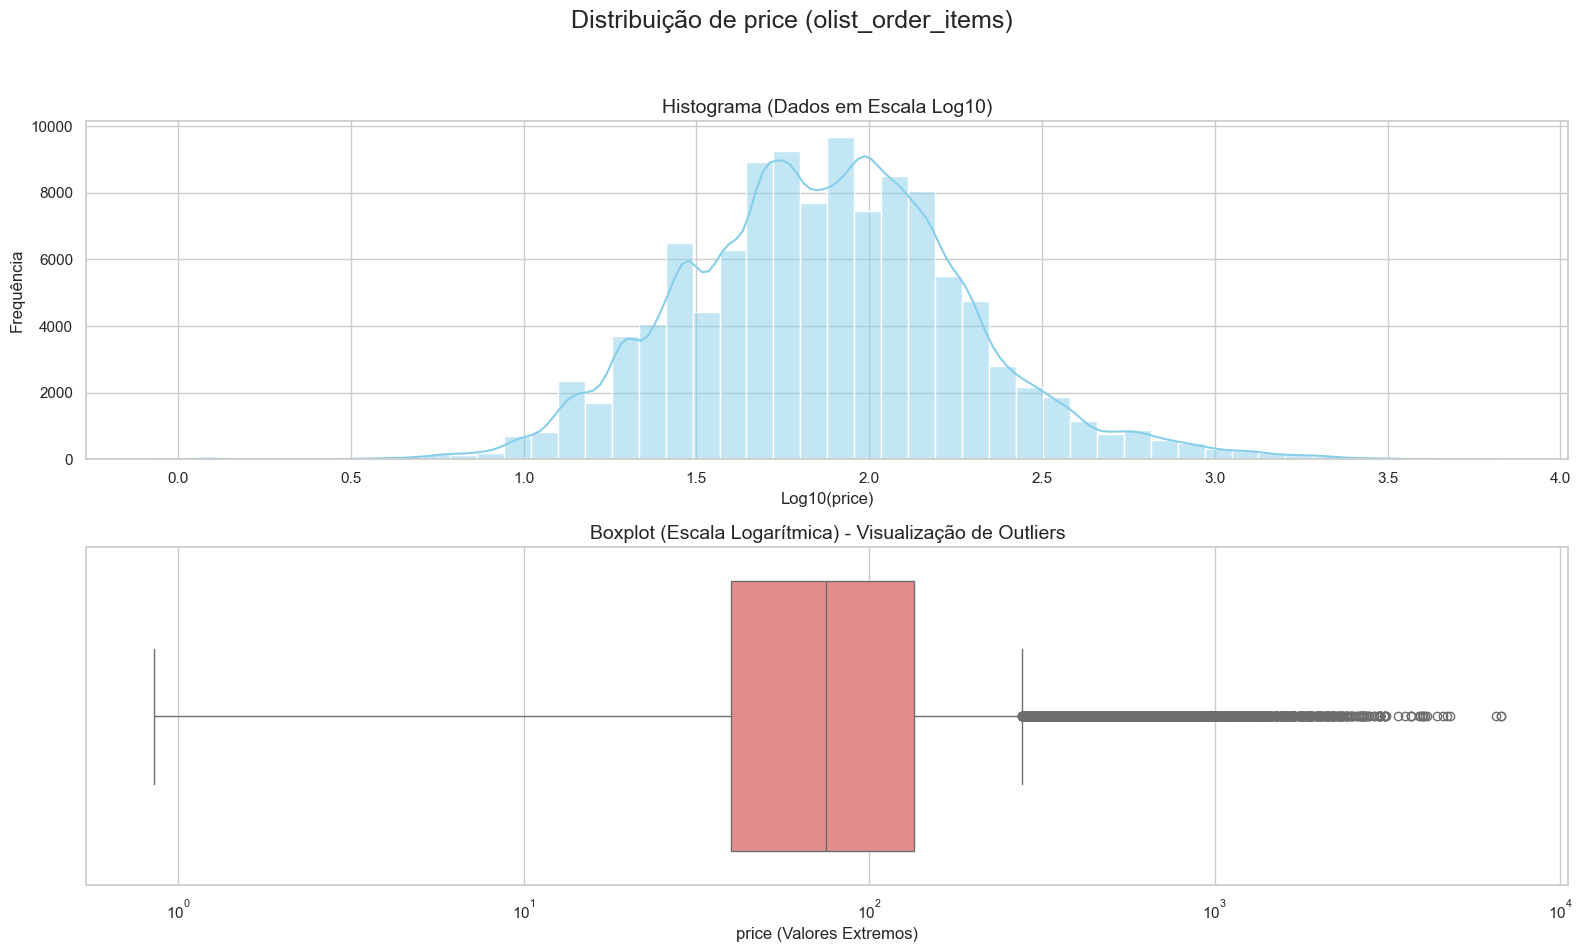


--- Analisando Distribuição: olist_order_items - freight_value ---


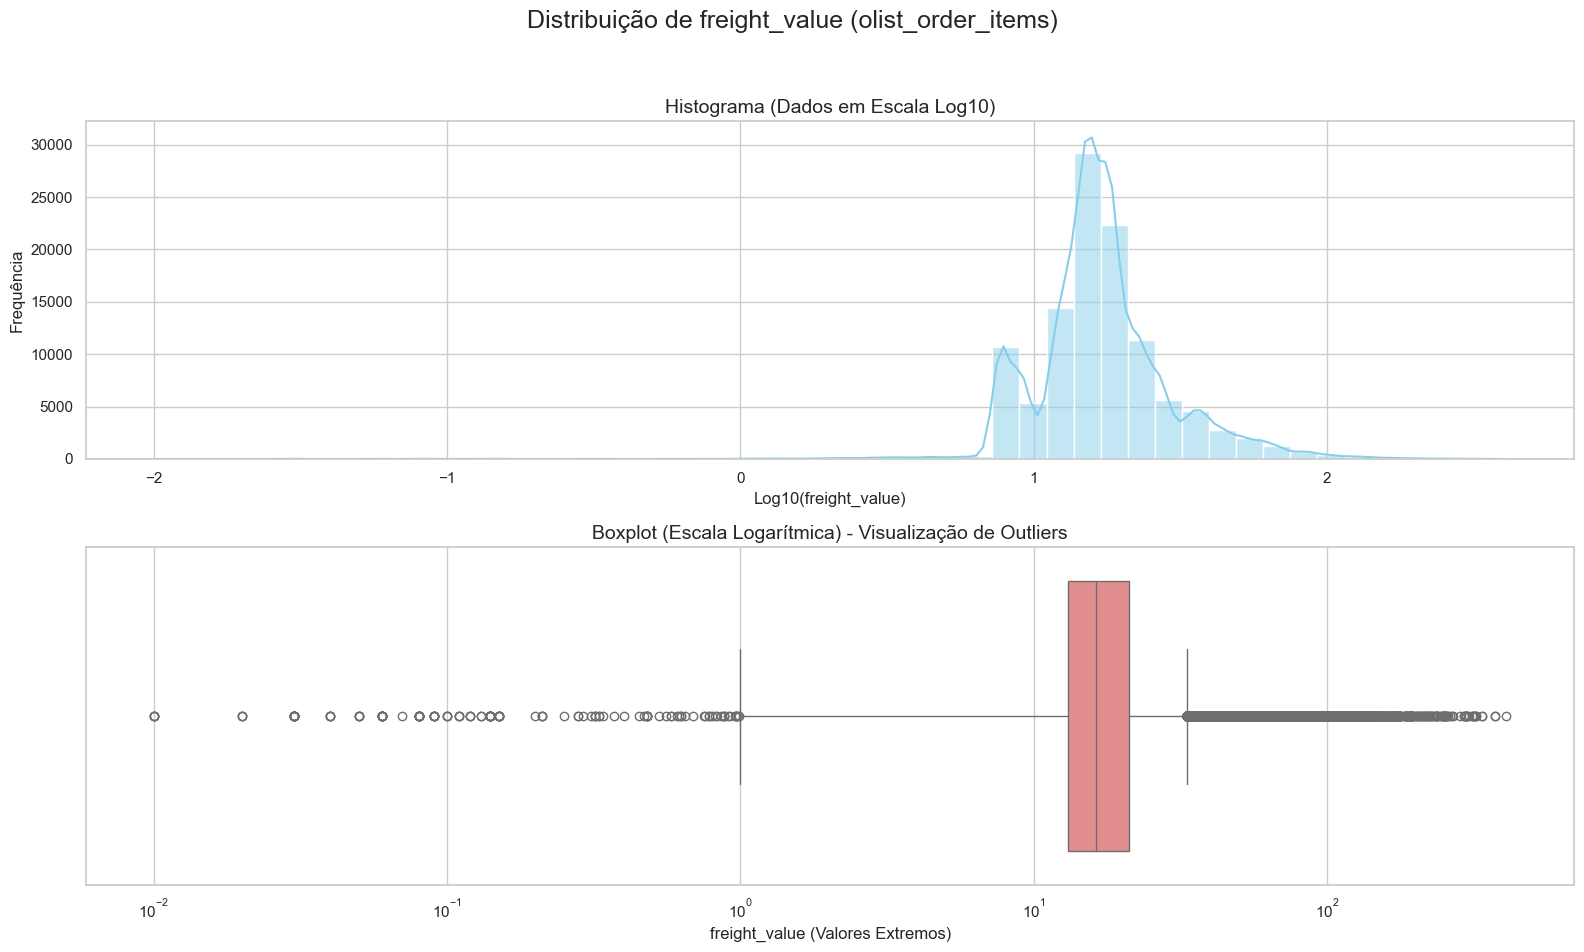


--- Analisando Distribuição: olist_order_payments - payment_value ---


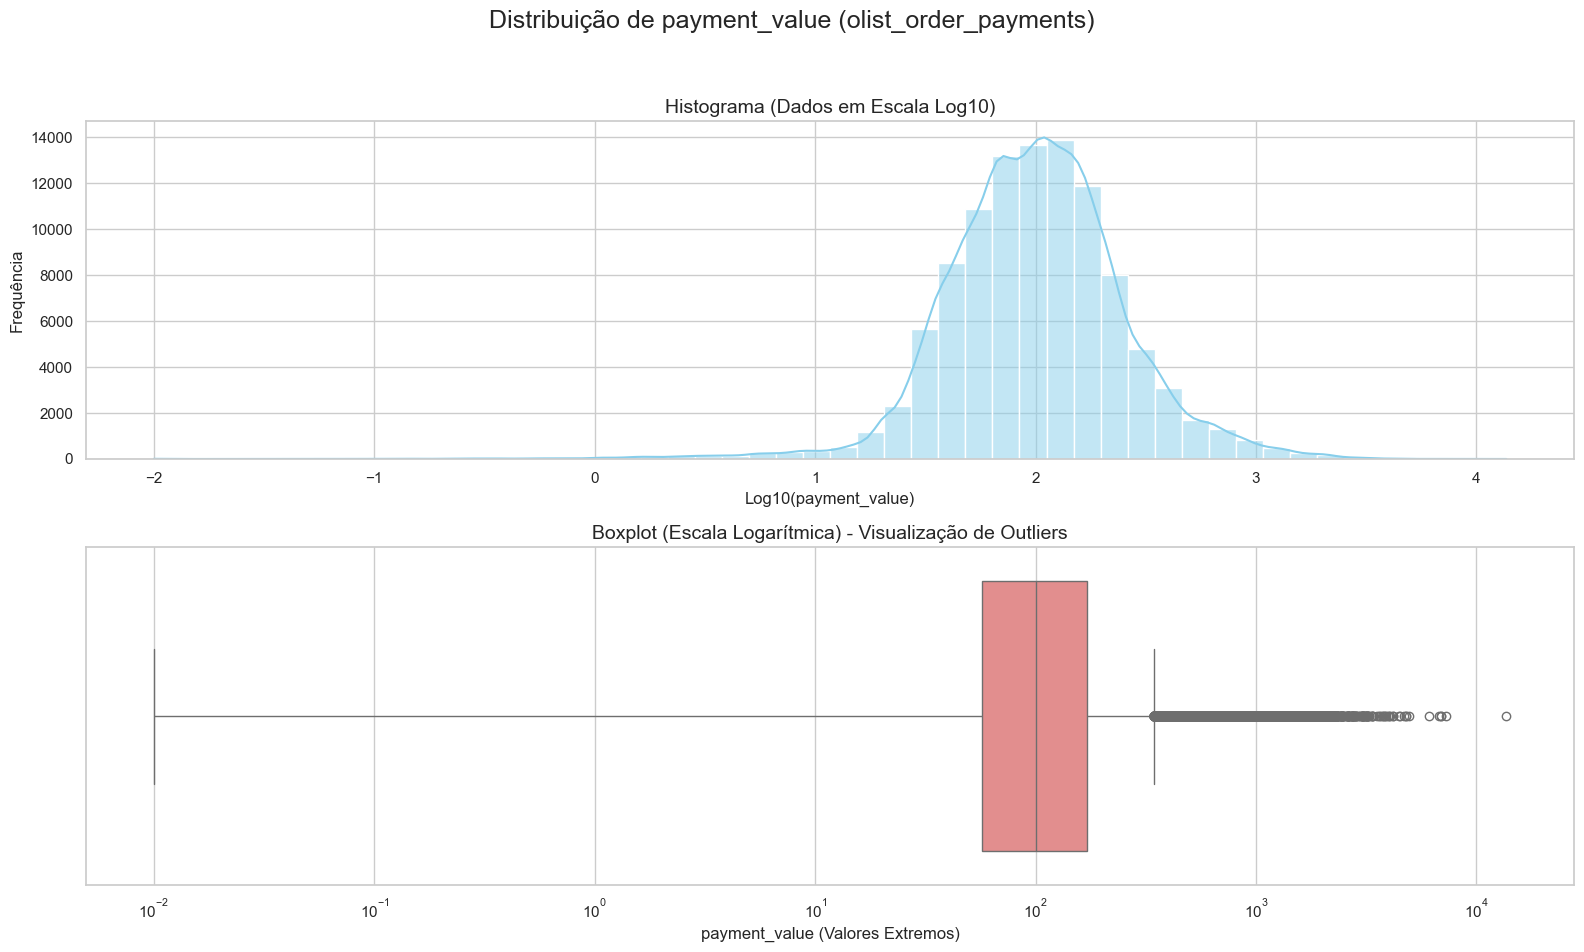

In [6]:
colunas_para_plotar = {
    'olist_order_items': ['price', 'freight_value'],
    'olist_order_payments': ['payment_value']
}

for nome_df, lista_colunas in colunas_para_plotar.items():
    if nome_df not in dfs: continue
    
    df_temp = dfs[nome_df]
    
    for coluna in lista_colunas:
        print(f"\n--- Analisando Distribuição: {nome_df} - {coluna} ---")
        
        try:
            dados_pd = df_temp.select(coluna).filter(F.col(coluna).isNotNull() & (F.col(coluna) > 0)).toPandas()
        except Exception as e:
            print(f"Erro ao coletar dados para {coluna}: {e}. Pulando...")
            continue
            
        if dados_pd.empty:
            print(f"Nenhum dado positivo encontrado para {coluna} após filtros.")
            continue

        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        fig.suptitle(f'Distribuição de {coluna} ({nome_df})', fontsize=18)

        log_data = np.log10(dados_pd[coluna])
        sns.histplot(log_data, bins=50, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Histograma (Dados em Escala Log10)', fontsize=14)
        axes[0].set_xlabel(f'Log10({coluna})', fontsize=12)
        axes[0].set_ylabel('Frequência', fontsize=12)

        sns.boxplot(x=dados_pd[coluna], ax=axes[1], color='lightcoral')
        axes[1].set_title('Boxplot (Escala Linear) - Visualização de Outliers', fontsize=14)
        axes[1].set_xlabel(f'{coluna} (Valores Extremos)', fontsize=12)
        
        try:
            axes[1].set_xscale('log')
            axes[1].set_title('Boxplot (Escala Logarítmica) - Visualização de Outliers', fontsize=14)
        except ValueError:
            pass

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### **Interpretação dos Gráficos de Distribuição**

* **Histogramas (Log Scale):** A transformação logarítmica (Log10) foi essencial. Ela revela a distribuição log-normal dos dados financeiros (`price`, `freight_value`), que estava "esmagada" em uma única barra na escala linear. Isso é um comportamento típico de dados de preço e valor.

* **Boxplots:** A "caixa" (o IQR, 50% dos dados) é pequena, mas há uma longa cauda de pontos (outliers) se estendendo muito além do limite superior.

* **Conclusão:** A visualização confirma que os outliers não são apenas alguns pontos, mas uma característica significativa da distribuição. O tratamento é **mandatório** no ETL para garantir que as métricas na camada Prata sejam robustas e reflitam a realidade da maioria dos pedidos, e não sejam distorcidas por esses valores extremos.

## 6. Análise de Variáveis Categóricas

Agora, analisamos as principais colunas categóricas para entender o perfil do negócio. Aqui, gráficos de barras são apropriados para mostrar frequências.

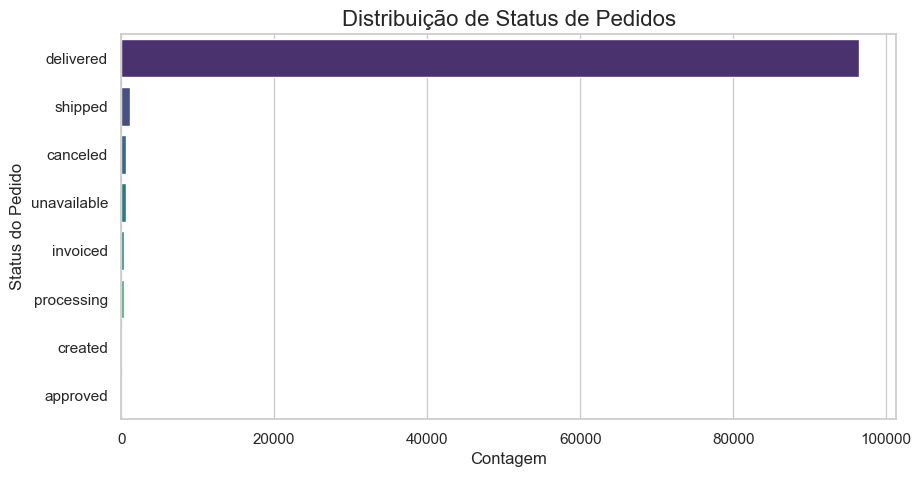

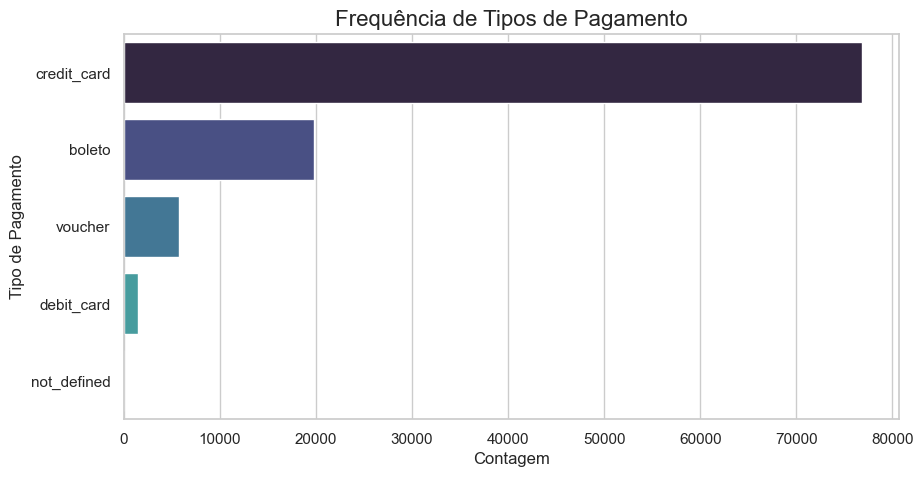

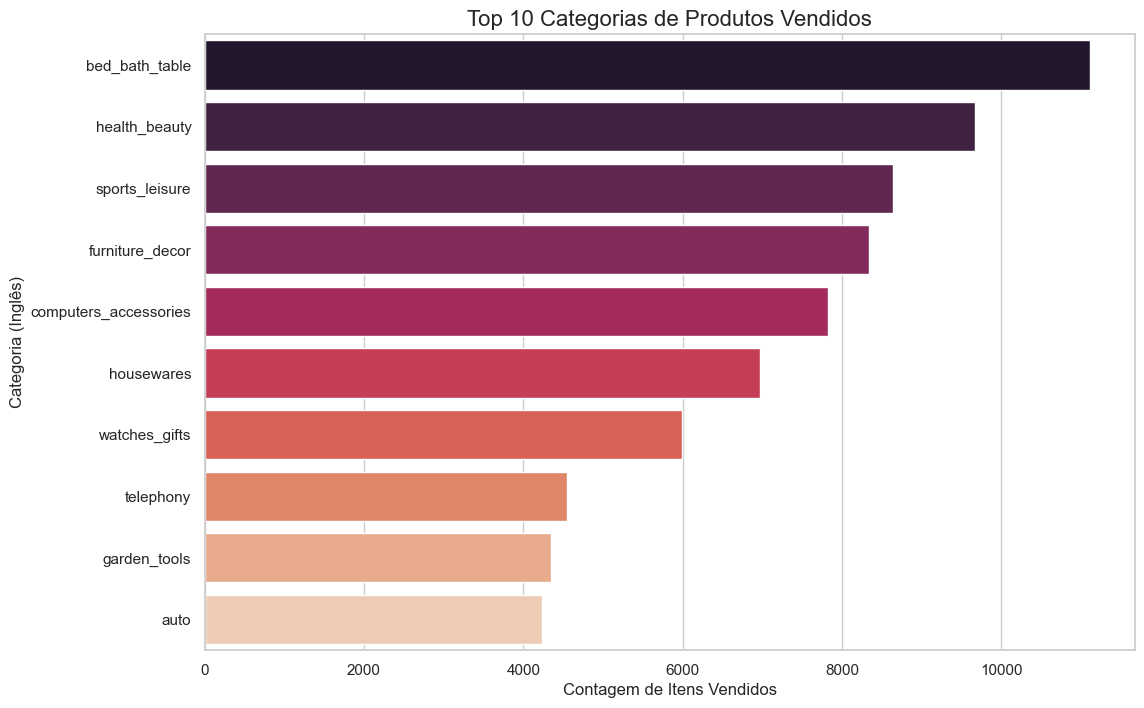

In [7]:
plt.figure(figsize=(10, 5))
status_counts_pd = dfs['olist_orders'].groupBy('order_status').count().orderBy('count', ascending=False).toPandas()
sns.barplot(data=status_counts_pd, x='count', y='order_status', palette='viridis', hue='order_status', legend=False)
plt.title('Distribuição de Status de Pedidos', fontsize=16)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Status do Pedido', fontsize=12)
plt.show()

plt.figure(figsize=(10, 5))
payment_counts_pd = dfs['olist_order_payments'].groupBy('payment_type').count().orderBy('count', ascending=False).toPandas()
sns.barplot(data=payment_counts_pd, x='count', y='payment_type', palette='mako', hue='payment_type', legend=False)
plt.title('Frequência de Tipos de Pagamento', fontsize=16)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Tipo de Pagamento', fontsize=12)
plt.show()

try:
    top_categorias_pd = dfs['olist_order_items'] \
        .join(dfs['olist_products'], "product_id", "left") \
        .join(dfs['product_category_name_translation'], "product_category_name", "left") \
        .filter(F.col("product_category_name_english").isNotNull()) \
        .groupBy('product_category_name_english').count() \
        .orderBy('count', ascending=False).limit(10).toPandas()

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categorias_pd, x='count', y='product_category_name_english', palette='rocket', hue='product_category_name_english', legend=False)
    plt.title('Top 10 Categorias de Produtos Vendidos', fontsize=16)
    plt.xlabel('Contagem de Itens Vendidos', fontsize=12)
    plt.ylabel('Categoria (Inglês)', fontsize=12)
    plt.show()
except Exception as e:
    print(f"Erro ao gerar gráfico de categorias: {e}")

## 7. Análise de Qualidade: O Problema da `review_score`

Como identificado na análise estrutural, a coluna `review_score` é do tipo `string`. Isso indica que, além dos números (1-5), ela contém lixo textual. Vamos limpar essa coluna *temporariamente* para a análise e visualizar a distribuição real das notas.

Contagem de Notas de Avaliação Válidas (1 a 5):
+-----------+-----+
|score_limpa|count|
+-----------+-----+
|          1|11424|
|          2| 3151|
|          3| 8179|
|          4|19142|
|          5|57328|
+-----------+-----+



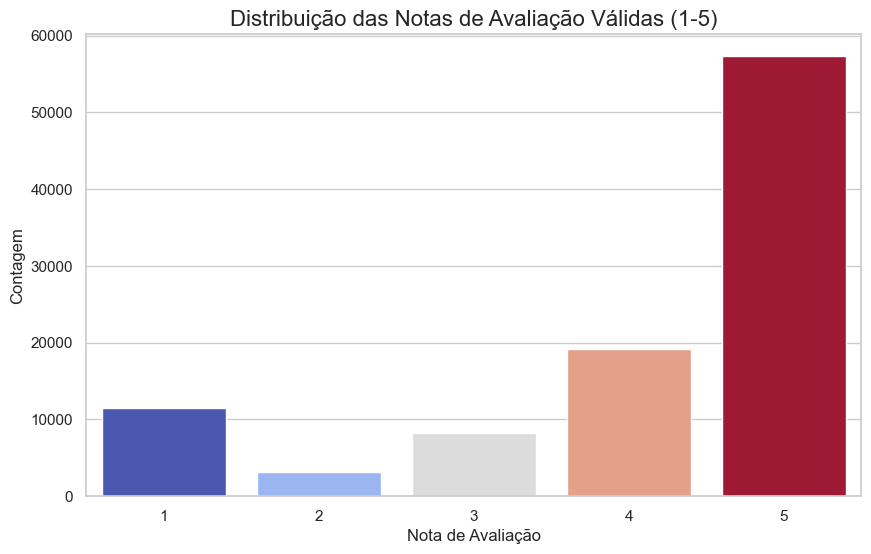

In [8]:
reviews_df_limpo = dfs['olist_order_reviews'].withColumn(
    "score_limpa",
    F.expr("try_cast(review_score as int)")
)

review_scores_contagem_df = reviews_df_limpo.filter(
    (F.col("score_limpa").isNotNull()) &
    (F.col("score_limpa").between(1, 5))
).groupBy('score_limpa').count().orderBy('score_limpa')

print("Contagem de Notas de Avaliação Válidas (1 a 5):")
review_scores_contagem_df.show()

review_scores_pd = review_scores_contagem_df.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(
    data=review_scores_pd, 
    x='score_limpa', 
    y='count', 
    palette='coolwarm', 
    hue='score_limpa',
    legend=False
)
plt.title('Distribuição das Notas de Avaliação Válidas (1-5)', fontsize=16)
plt.xlabel('Nota de Avaliação', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.show()

## 8. Análise de Correlações

Finalmente, vamos investigar a correlação entre as principais métricas numéricas para entender como elas se influenciam. Será criado um DataFrame analítico temporário para esta finalidade, unindo dados de pedidos, itens e avaliações.

Preparando DataFrame para análise de correlação...
Calculando matriz de correlação...


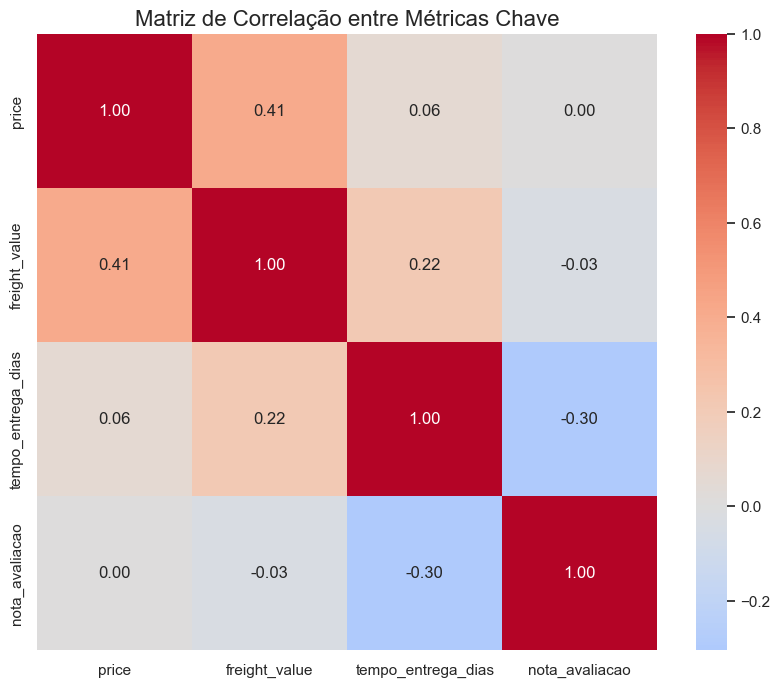


Principais Correlações:
                       price  freight_value  tempo_entrega_dias  \
price               1.000000       0.411017            0.062566   
freight_value       0.411017       1.000000            0.215208   
tempo_entrega_dias  0.062566       0.215208            1.000000   
nota_avaliacao      0.003259      -0.032863           -0.303812   

                    nota_avaliacao  
price                     0.003259  
freight_value            -0.032863  
tempo_entrega_dias       -0.303812  
nota_avaliacao            1.000000  


In [9]:
print("Preparando DataFrame para análise de correlação...")

df_reviews_limpo = dfs['olist_order_reviews'].withColumn(
    "nota_avaliacao", F.expr("try_cast(review_score as int)")
).filter(F.col("nota_avaliacao").between(1, 5))

df_pedidos_com_datas = dfs['olist_orders'].withColumn(
    "tempo_entrega_dias", F.datediff(F.col("order_delivered_customer_date"), F.col("order_purchase_timestamp"))
)

df_corr_base = dfs['olist_order_items'] \
    .join(df_pedidos_com_datas, "order_id", "left") \
    .join(df_reviews_limpo, "order_id", "left")

colunas_corr = ["price", "freight_value", "tempo_entrega_dias", "nota_avaliacao"]
df_corr_spark = df_corr_base.select(colunas_corr).dropna()

print("Calculando matriz de correlação...")
try:
    df_corr_pd = df_corr_spark.toPandas()
    
    correlation_matrix = df_corr_pd.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix, 
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0
    )
    plt.title('Matriz de Correlação entre Métricas Chave', fontsize=16)
    plt.show()
    
    print("\nPrincipais Correlações:")
    print(correlation_matrix)
    
except Exception as e:
    print(f"Erro ao gerar matriz de correlação: {e}")

### **Interpretação da Matriz de Correlação**

O heatmap revela o insight de negócio mais acionável de toda a análise:

* **Correlação Chave (`tempo_entrega_dias` vs `nota_avaliacao`):** A correlação negativa de **-0.30** é estatisticamente significativa. Ela **prova** que existe uma relação direta: **quanto maior o tempo de entrega, menor é a nota de avaliação do cliente.**
* **Implicação:** Isso justifica o foco do negócio em eficiência logística como um pilar da satisfação do cliente e valida a criação dessas duas métricas no nosso ETL.
* **Outras Correlações:** As correlações entre `price` e `freight_value` (0.41) e `freight_value` e `tempo_entrega_dias` (0.22) são moderadas e esperadas (produtos mais caros/pesados têm fretes mais caros, que podem demorar mais).

## 9. Conclusões da Análise Exploratória

A análise exploratória da camada Bronze foi concluída e revelou diversos pontos críticos de qualidade de dados, distribuição e regras de negócio. Estas descobertas irão guiar e justificar todas as etapas de transformação no pipeline de ETL.

O plano de ação para a construção da Camada Prata será:

### 1. Tratamento de Qualidade de Dados

* **Tipos de Dados (`review_score`):** A coluna `review_score` será tratada. Ela foi identificada como `string` e os dados brutos confirmam a presença de lixo textual. No ETL, usaremos a função **`try_cast(review_score as int)`** para converter apenas os valores numéricos válidos e transformar todo o resto em `NULL`, garantindo um pipeline resiliente.
* **Tipos de Dados (Finanças):** Colunas como `price`, `freight_value` e `payment_value` serão convertidas para o tipo `DecimalType(10, 2)` para garantir a precisão monetária correta no Data Warehouse.

### 2. Tratamento de Valores Ausentes

* **Categorias (`product_category_name`):** A coluna de categoria de produto possui ~610 nulos. No ETL, esses nulos serão imputados com uma categoria padrão (ex: `'desconhecida'`) usando a função `coalesce` para garantir a consistência.
* **Datas (`order_delivered...`):** Os nulos nas colunas de data de entrega são esperados (pedidos cancelados/em processamento) e serão mantidos como `NULL`, pois representam o estado real da transação.

### 3. Tratamento de Outliers

* **`price`, `freight_value`, `payment_value`:** A análise estatística (`.describe()`) e visual (Boxplots e Histogramas) confirmou a presença de **outliers extremos** nessas colunas.
* **Ação no ETL:** Para criar métricas de negócio robustas (como médias) que não sejam distorcidas, esses outliers serão tratados. Será aplicado o **método estatístico IQR (Interquartile Range)** para identificar e **remover** os registros que caem fora dos limites aceitáveis (além de 1.5 * IQR) antes de salvar na Camada Prata.

### 4. Engenharia de Features

* **Novas Colunas:** O ETL irá materializar as colunas analíticas que validamos:
    * `tempo_entrega_dias`: (Cálculo) `datediff(order_delivered_customer_date, order_purchase_timestamp)`.
    * `atraso_na_entrega`: (Flag Booleana) `order_delivered_customer_date > order_estimated_delivery_date`.
* **Insights:** A correlação negativa de **-0.30** entre `tempo_entrega_dias` e `nota_avaliacao` valida a importância de criar e monitorar essas novas métricas.

Com essas ações, o ETL transformará os dados brutos em uma Camada Prata limpa, unificada, robusta contra outliers e enriquecida com novas métricas, pronta para a modelagem da Camada Ouro.